## Yahoo Finance experimentation

In [1]:
import yfinance as yf
import os
import time
import requests
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional
from bs4 import BeautifulSoup
import feedparser
import json

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Get stock information for Apple (AAPL)
ticker = "AAPL"
stock = yf.Ticker(ticker)


info = stock.info
print(f"Company: {info.get('longName', 'N/A')}")
print(f"Sector: {info.get('sector', 'N/A')}")
print(f"Current Price: ${info.get('currentPrice', 'N/A')}")
print(f"Market Cap: ${info.get('marketCap', 'N/A'):,}")

# Get historical data for the last 30 days
hist_data = stock.history(period="1mo")
print(f"\nLatest closing price: ${hist_data.iloc[-1]['Close']:.2f}")
print(f"30-day high: ${hist_data['High'].max():.2f}")
print(f"30-day low: ${hist_data['Low'].min():.2f}")

Company: Apple Inc.
Sector: Technology
Current Price: $256.62
Market Cap: $3,808,340,738,048

Latest closing price: $256.60
30-day high: $257.36
30-day low: $224.69


Data with Moving Average and Daily Returns:
                                Close  20_Day_MA  Daily_Return
Date                                                          
2025-03-26 00:00:00-04:00  220.989059        NaN           NaN
2025-03-27 00:00:00-04:00  223.303406        NaN      1.047267
2025-03-28 00:00:00-04:00  217.367935        NaN     -2.658030
2025-03-31 00:00:00-04:00  221.587616        NaN      1.941262
2025-04-01 00:00:00-04:00  222.645020        NaN      0.477194


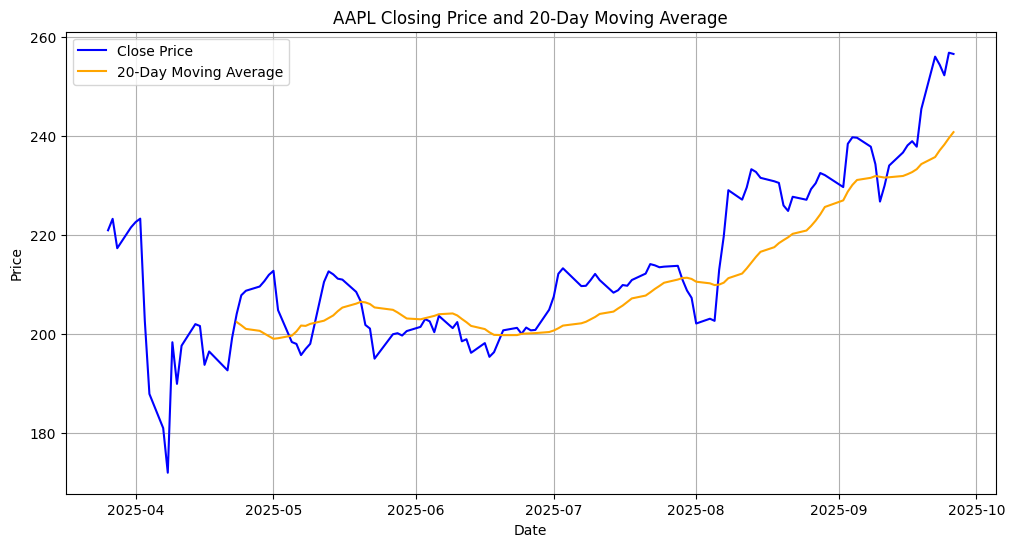

In [3]:
# plot info
symbol = 'AAPL'

stock = yf.Ticker(symbol)
info = stock.info
data = stock.history(period="6mo")

data['20_Day_MA'] = data['Close'].rolling(window=20).mean()

data['Daily_Return'] = data['Close'].pct_change() * 100

print("Data with Moving Average and Daily Returns:")
print(data[['Close', '20_Day_MA', 'Daily_Return']].head())

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['20_Day_MA'], label='20-Day Moving Average', color='orange')
plt.title(f'{symbol} Closing Price and 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Get Complete Stock data 

Reference: https://www.geeksforgeeks.org/python/getting-stock-symbols-with-yfinance-in-python/


In [4]:
def fetch_stock_info(symbol, period: str = "1y"):
    """
        Fetch stock data using yfinance.
        
        Args:
            symbol: Stock ticker symbol
            period: Data period (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max)
        Returns:
            A dictionary with stock metrics and historical data.
    """
    stock = yf.Ticker(symbol)
    
    # Get historical data and info
    hist = stock.history(period=period)
    info = stock.info
    
    # Calculate basic metrics
    current_price = hist['Close'].iloc[-1]
    prev_close = info.get('previousClose', hist['Close'].iloc[-2])
    price_change = current_price - prev_close
    price_change_pct = (price_change / prev_close) * 100
    
    # Calculate volatility (30-day)
    returns = hist['Close'].pct_change().dropna()
    volatility = returns.tail(30).std() * (252 ** 0.5)  # Annualized
    
    # Get volume metrics
    avg_volume = hist['Volume'].tail(30).mean()
    current_volume = hist['Volume'].iloc[-1]
    
    result = {
        "symbol": symbol,
        "current_price": float(current_price),
        "price_change": float(price_change),
        "price_change_pct": float(price_change_pct),
        "volume": int(current_volume),
        "avg_volume_30d": float(avg_volume),
        "volatility_30d": float(volatility),
        "market_cap": info.get("marketCap"),
        "pe_ratio": info.get("forwardPE"),
        "dividend_yield": info.get("dividendYield"),
        "52_week_high": info.get("fiftyTwoWeekHigh"),
        "52_week_low": info.get("fiftyTwoWeekLow"),
        "beta": info.get("beta"),
        "sector": info.get("sector"),
        "industry": info.get("industry"),
        "company_summary": info.get("longBusinessSummary", "")[:500],
        "historical_data": hist.tail(30).to_dict('records'),
        "timestamp": datetime.now().isoformat()
    }
    
    return result

In [5]:
tsla = fetch_stock_info("TSLA")
pprint(tsla)

{'52_week_high': 488.54,
 '52_week_low': 212.11,
 'avg_volume_30d': 86416013.83333333,
 'beta': 2.065,
 'company_summary': 'Tesla, Inc. designs, develops, manufactures, leases, and '
                    'sells electric vehicles, and energy generation and '
                    'storage systems in the United States, China, and '
                    'internationally. The company operates in two segments, '
                    'Automotive; and Energy Generation and Storage. The '
                    'Automotive segment offers electric vehicles, as well as '
                    'sells automotive regulatory credits; and non-warranty '
                    'after-sales vehicle, used vehicles, body shop and parts, '
                    'supercharging, retail merchandise, and vehicle insurance '
                    'services. Thi',
 'current_price': 433.2200012207031,
 'dividend_yield': None,
 'historical_data': [{'Close': 330.55999755859375,
                      'Dividends': 0.0,
             

## Collect Information from News Sources

In [6]:
symbol = "MSFT"

limit=10
news_sources = []

#############
# Scrape Yahoo
yahoo_rss = f"https://feeds.finance.yahoo.com/rss/2.0/headline?s={symbol}&region=US&lang=en-US"
yahoo_feed = feedparser.parse(yahoo_rss)

for entry in yahoo_feed.entries[:limit//2]:
    news_sources.append({
        "title": entry.title,
        "link": entry.link,
        "published": entry.get("published", ""),
        "summary": entry.get("summary", ""),
        "source": "Yahoo Finance"
        })


############# 
# Scrape NEWSAPI
news_api_key = os.getenv("NEWS_API_KEY")
url = "https://newsapi.org/v2/everything"
params = {
    "q": f"{symbol} stock",
    "language": "en",
    "sortBy": "publishedAt",
    "pageSize": limit//2,
    "apiKey": news_api_key
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    for article in data.get("articles", []):
        news_sources.append({
            "title": article["title"],
            "link": article["url"],
            "published": article["publishedAt"],
            "summary": article.get("description", ""),
            "source": article["source"]["name"]
        })

In [7]:
# Print information
for news in news_sources:
    pprint(news)

{'link': 'https://finance.yahoo.com/news/sector-tech-stocks-advance-friday-174148876.html?.tsrc=rss',
 'published': 'Fri, 26 Sep 2025 17:41:48 +0000',
 'source': 'Yahoo Finance',
 'summary': 'Tech stocks were higher Friday afternoon, with the Technology '
            'Select Sector SPDR Fund (XLK) adding 0',
 'title': 'Sector Update: Tech Stocks Advance Friday Afternoon'}
{'link': 'https://finance.yahoo.com/news/michigan-bitcoin-bill-gains-momentum-173107534.html?.tsrc=rss',
 'published': 'Fri, 26 Sep 2025 17:31:07 +0000',
 'source': 'Yahoo Finance',
 'summary': 'Michigan has gotten one step closer to adopting Bitcoin as a '
            'reserve asset. \u200b House Bill 4087 finally made progress last '
            'week after stalling for seven months. Lawmakers moved the bill to '
            'a second reading and referred it to the Government Operations ...',
 'title': 'Michigan Bitcoin Reserve Bill Gains Momentum After Months-Long '
          'Pause: Will The Great Lakes State Be T